# 8.프로젝트: 뉴스기사 요약해보기

# Step 0. 데이터 준비하기

In [44]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1. 데이터 수집하기

뉴스 기사 데이터(news_summary_more.csv)를 다운로드

In [45]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [46]:
print('전체 데이터 수 :', (len(data)))

전체 데이터 수 : 98401


다운로드 받은 데이터(news_summary_more.csv)는 총 98401개

In [47]:
data.sample(10)

,headlines,text
87284,Will Smith's son Jaden claims hotel kicked him...,Hollywood actor Will Smith's son Jaden Smith h...
782,India 1st to use final stage of rocket as orbi...,India on Thursday became the first country to ...
67051,18 farmers die after inhaling pesticides in Ma...,At least 18 farmers died and over 400 farm lab...
77418,Only treated sewage to flow into water from 20...,Bengaluru Development Minister K J George has ...
34581,Amazon added more jobs in '17 than Google pare...,E-commerce giant Amazon's CEO Jeff Bezos has s...
24077,"NHRC notice to Delhi, Centre over death of 3 m...",The National Human Rights Commission (NHRC) ha...
21932,Harvard Business School dean Nohria to quit Ta...,Harvard Business School's India-born dean Niti...
53797,"Was a bit afraid of wearing panty, pad in 'Pad...","Akshay Kumar, on being asked if he had any res..."
78352,"US Senate clears new sanctions against Russia,...",The US Senate on Thursday voted 98-2 to impose...
88930,Rajinikanth's next film not based on Haji Mast...,The makers of Rajinikanth's yet-untitled next ...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성  
추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습  
추출적 요약의 경우는 오직 text열만을 사용

# Step 2. 데이터 전처리하기 (추상적 요약)

## 2-1 데이터 정리하기

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

데이터의 중복 샘플 유무를 확인

In [48]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


전체 데이터 수 : 98401로 text 열에서 41개 중복, headlines 열에서 121개 중복이 존재함을 알 수 있다.

데이터프레임의 drop_duplicates()를 사용, 중복 샘플을 제거

In [49]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


만약 데이터 Null 값을 가지는 샘플이 있었다면, Null 값 한 개가 남아있게 됨  
데이터프레임에 Null 값이 있는지 확인하는 방법은 .isnull().sum()을 사용

In [50]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null 값이 없음을 확인 (만약 Null 값이 있을 경우는 dropna() 함수를 사용하여 제거한다.)

### 텍스트 정규화와 불용어 제거

살아남은 98360개의 샘플에는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우들이 있다.  

텍스트 정규화(text normalization)  
기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는,  
기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법

텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성

In [51]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어(stopwords)  
텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어  
여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거

In [52]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

LTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개  
이를 사용하여 불용어를 제거  
모든 영어 문자는 소문자로 만들기  
섞여있는 html 태그를 제거  
정규 표현식을 통해 각종 특수문자를 제거  

함수의 하단을 보면, NLTK를 이용해 불용어를 제거시  
text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 headlines 전처리할 때는 호출하지 않는다.  
Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines 에는 남아 있는 게 낫기 때문.  

In [53]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

훈련 데이터 전체에 대해서 전처리를 수행

먼저 text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력

In [54]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

headlines 에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣는다.

In [55]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장  
빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체

In [56]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

.isnull().sum()을 사용해서 Null 값이 생겼는지 확인

In [57]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

둘다 Null 값이 없음을 확인

## 2-2 훈련데이터와 테스트데이터 나누기

학습에 사용할 데이터의 크기를 결정  
문장의 시작과 끝을 표시하기

#### 샘플의 최대 길이 정하기  
훈련에 사용할 샘플의 최대 길이를 정해줄 차례    
text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화 하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534


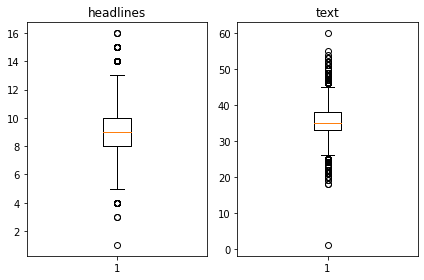

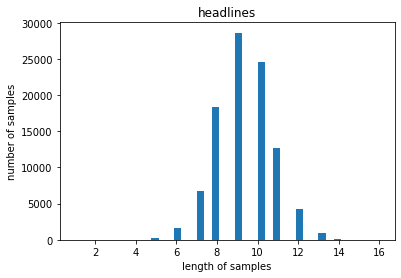

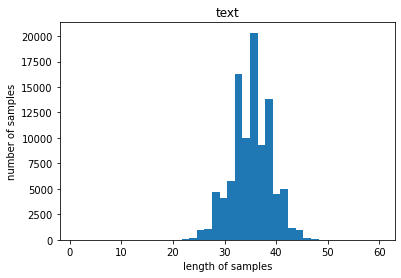

In [58]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

text 와 headlines 의 최대 길이는 모든 데이터가 포함 될수 있도록 지정한다.  

In [59]:
text_max_len = 60  
headlines_max_len = 16

각각 60과 16로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이  
객관적으로 길이를 결정하는 데 도움

훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단

In [60]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

함수를 text와 headlines에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있다.

In [61]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


### 시작 토큰과 종료 토큰 추가하기

디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춘다.  
seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가  

이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가  

디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input,  
디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target라고 정하기  

두 개의 문장 모두 headlines 열로부터 만들기  

In [62]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장하기

In [63]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터와 테스트 데이터를 분리  
직접 코딩을 통해서 분리 시작하기

우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기

In [64]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[93560 54288 48893 ... 93707  8854 85147]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의하여 잘 섞인 샘플 만들기

In [65]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리  
전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의

In [66]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


테스트 데이터의 개수를 이용해 전체 데이터를 양분 ( :표시의 위치에 주의)

In [67]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


훈련 데이터 78,688개  
테스트 데이터 19,672개

##  2-3 정수 인코딩

### 단어 집합(vocabu lary) 만들기 및 정수 인코딩  
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 한다.  
이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요  
이 과정을 단어 집합(vocabulary) 을 만든다고 표현

훈련 데이터에 대해서 단어 집합을 만들기  
우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들어 보기  
(Keras의 토크나이저를 사용)

In [68]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여됨  
현재 생성된 단어 집합은 src_tokenizer.word_index에 저장  
단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인  
src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

In [69]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69604
등장 빈도가 6번 이하인 희귀 단어의 수: 47447
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22157
단어 집합에서 희귀 단어의 비율: 68.16705936440435
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.490215399853241


등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거  
이를 제외한 단어 집합의 크기를 2만여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 20,000으로 제한  
토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다

In [70]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행

In [71]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3194, 4340, 1256, 1755, 129, 1658, 1047, 5703, 1005, 27, 6260, 256, 5003, 69, 108, 1323, 16001, 6332, 1047, 1624, 3503, 586, 417, 6260, 5414, 335, 1175, 9489, 1047, 8677, 17499, 233, 5004, 19470], [1668, 283, 3099, 3206, 3924, 747, 1616, 67, 189, 79, 270, 1638, 1129, 827, 4580, 722, 171, 779, 1, 722, 8042, 5704, 283, 779, 1, 2109, 722, 56, 171], [218, 2885, 311, 255, 1564, 347, 3279, 3954, 3258, 248, 190, 119, 311, 1, 7919, 1505, 1821, 4, 1686, 775, 855, 243, 5005, 351, 7790, 139, 3925, 76, 1243, 311, 1290, 872, 3954, 3258, 4844]]


headlines 데이터에 대해서도 동일한 작업을 수행  
케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산

In [72]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여 후 tar_tokenizer.word_index에 저장  
tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장  
이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [73]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30126
등장 빈도가 5번 이하인 희귀 단어의 수: 19695
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10431
단어 집합에서 희귀 단어의 비율: 65.37542322246564
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.650425245200875


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 66%를 차지  
아까 했던 것과 동일하게 이 단어들은 모두 제거  
어림잡아 10,000을 단어 집합의 크기로 제한

In [74]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1694, 7672, 1315, 6, 236, 3587, 4, 1650, 5198], [1, 229, 1024, 233, 11, 941, 14, 6832, 1160], [1, 251, 2986, 2733, 4, 5012, 4, 252], [1, 30, 2393, 1181, 7248, 4520, 9542], [1, 338, 4670, 9543, 1144, 110, 37, 1316, 477, 4, 59]]
target
decoder  [[1694, 7672, 1315, 6, 236, 3587, 4, 1650, 5198, 2], [229, 1024, 233, 11, 941, 14, 6832, 1160, 2], [251, 2986, 2733, 4, 5012, 4, 252, 2], [30, 2393, 1181, 7248, 4520, 9542, 2], [338, 4670, 9543, 1144, 110, 37, 1316, 477, 4, 59, 2]]


빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성    
headlines 경우에는 이 현상이 굉장히 두드러졌을 가능성     
요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태 길이가 0이 된 요약문의 실제 길이는 1로 나온다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장 이 샘플들은 모두 삭제

In [75]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인

### 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면,  
이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 한다.  
아까 정해두었던 최대 길이로 패딩하기 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰주기

In [76]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# Step 3. 모델 설계하기

우선 함수형 API를 이용해서 인코더를 설계

In [77]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의 hidden state의 크기를 256으로 정의,  
hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터  
이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해, 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니다.

인코더의 LSTM은 총 3개의 층으로 구성  
3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼수 있음  
3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야 한다.

LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용  

일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법  

반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식,즉 time step의 입력을 랜덤으로 생략  
regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다.  

참고로 recurrent dropout을 사용하면 경고문이 뜬다.  
recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸린다.

디코더를 설계한다

In [78]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일 LSTM의 입력을 정의할 때,     
initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다.

디코더 출력층 설계

In [79]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      2560000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다.   
그렇기 때문에 Dense의 인자로 tar_vocab을 주고   
활성화 함수로 소프트맥스 함수를 사용  

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq    
디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법-> 어텐션 메커니즘

# Step 4.  어텐션 메커니즘 사용하기 (추상적 요약)

### 어텐션 메커니즘

어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻    
여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼 것    
참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션  

어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정 해보기

In [80]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      2560000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용  
어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동  

## 모델 훈련하기

In [81]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 260s 819ms/step - loss: 4.2700 - val_loss: 3.9190
Epoch 2/50
308/308 [==============================] - 249s 808ms/step - loss: 3.8257 - val_loss: 3.6500
Epoch 3/50
308/308 [==============================] - 249s 808ms/step - loss: 3.5584 - val_loss: 3.4448
Epoch 4/50
308/308 [==============================] - 249s 809ms/step - loss: 3.3607 - val_loss: 3.2938
Epoch 5/50
308/308 [==============================] - 248s 807ms/step - loss: 3.2037 - val_loss: 3.1918
Epoch 6/50
308/308 [==============================] - 248s 805ms/step - loss: 3.0749 - val_loss: 3.1094
Epoch 7/50
308/308 [==============================] - 249s 807ms/step - loss: 2.9688 - val_loss: 3.0523
Epoch 8/50
308/308 [==============================] - 249s 809ms/step - loss: 2.8760 - val_loss: 2.9814
Epoch 9/50
308/308 [==============================] - 249s 808ms/step - loss: 2.7930 - val_loss: 2.9383
Epoch 10/50
308/308 [==============================] - 248s 807m

'조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할    

val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면,  
학습을 멈추도록 설정   

EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있다.

훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 하기

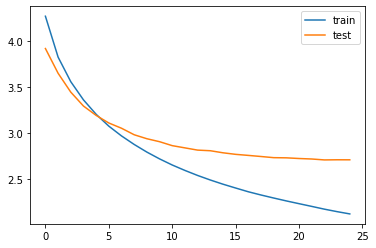

In [82]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 한다.  
필요한 3개의 사전을 아래와 같이 미리 준비한다

In [83]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음  
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음  
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.  

훈련 단계에서는  
디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로,  
인코더와 디코더를 엮은 통짜 모델 하나만 준비  

인퍼런스 단계에서는 (정답 문장이 없는)  
만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다.  
이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.  

In [84]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계

In [85]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들기

In [89]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트하기

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편함  
주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어본다.  

함수를 만들 때,  
text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고,  
headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만든다.

In [90]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


# Step 5. 실제 결과와 요약문 비교하기 (추상적 요약)

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보기

In [91]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : mumbai traffic police friday towed away car malad woman seven month old child inside vehicle video incident surfaced social media police officer involved case suspended woman reportedly breast feeding child police decided tow car illegal parking 
실제 요약 : mumbai cops away car with woman and child inside 
예측 요약 :  mumbai police rescue woman to save woman who saved her


원문 : boy biplab mother father west bengal nadia district took class exams together year three studied subjects school biplab alone took taught father mother finished mother passed father failed year 
실제 요약 : boy mother father appear for class exams together 
예측 요약 :  mother of daughter in class mother was not


원문 : responding rumoured girlfriend deepika padukone statement way arrive superstar ranveer singh said number one actress hindi cinema today long way go added rate highly actor said wants best actor possible 
실제 요약 : deepika is no actress of hindi cinema today ranveer singh 
예측 요약 :  deepika is the best choice

기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 있음  
심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 함  
그다지 좋지 않은 요약의 예도 꽤나 보임

성능 개선방법  

seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법  
빔 서치(beam search)  
사전 훈련된 워드 임베딩(pre-trained word embedding)  
인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)

# step 6. Summa을 이용해서 추출적 요약해보기

본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법  
패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공  

In [92]:
from summa.summarizer import summarize
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [93]:
data.sample(10)

,headlines,text
64272,Appointment of J&K interlocutor wonÃ¢ÂÂt aff...,Army Chief General Bipin Rawat has said that t...
18367,I did what: Sara Tendulkar celebrates graduati...,Former Indian cricketer Sachin Tendulkar's dau...
59931,British Airways flyers who have paid least to ...,British Airways has announced a group boarding...
23532,Biopics not going to die anytime soon: 'Mary K...,"Filmmaker Omung Kumar, who made his directoria..."
9505,One person is doing all he wants: Bedi on Kohl...,Talking about the fallout between Team India c...
14982,Tribal man carries wife to hospital after she ...,A tribal man carried his wife on his shoulders...
87406,"Terror alert in Delhi, Mumbai over possible Le...",Intelligence agencies have issued a terror ale...
29795,I don't want my son Taimur's life to be docume...,Actress Kareena Kapoor Khan has said that she ...
71886,Ground-to-air security cover in Delhi ahead of...,Delhi has been brought under a ground-to-air s...
71444,SL coach compares 'ruthless' India to New Zeal...,After India completed a 9-0 all-round whitewas...


summarize 사용하기

Summa의 summarize()의 인자로 사용되는 값  

text (str) : 요약할 테스트.  
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
words (int or None, optional) – 출력에 포함할 단어 수.  
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시  
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환  

summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행  
문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다.  

비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여본다. ( 원문의 0.005%만을 출력하도록 설정)  

중복 샘플과 NULL 값이 존재하는 샘플 제거

In [96]:
# 데이터의 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [97]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [98]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [102]:
data['headlines_predict'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

In [103]:
data.sample(10)

,headlines,text,headlines_predict
29007,Order for govt school teachers to take pic wit...,The Sitapur basic education department has wit...,The Sitapur basic education department has wit...
57436,X-Men director Bryan Singer accused of raping ...,"Bryan Singer, who directed the 'X-Men' films, ...","Bryan Singer, who directed the 'X-Men' films, ..."
29787,Drinking too much water may cause brain swelli...,Drinking too much water can cause excess fluid...,Drinking too much water can cause excess fluid...
88213,Free tools to unlock WannaCry without ransom r...,Researchers have released tools to help people...,Researchers have released tools to help people...
37027,Saqib Saleem to play villain in Salman's 'Daba...,"Actor Saqib Saleem, who recently starred in Sa...","Actor Saqib Saleem, who recently starred in Sa..."
57160,"Dhoni 2nd wicketkeeper in history to score 16,...",Former Indian captain MS Dhoni became the seco...,Former Indian captain MS Dhoni became the seco...
85188,"4 kg heroin, 3 kg smack seized from narcotics ...",The Punjab Police on Monday arrested inspector...,The Punjab Police on Monday arrested inspector...
16088,C'garh lake's floodgates opened after 10yrs am...,Two floodgates of Chandigarh's Sukhna Lake wer...,"The gates were last opened in 2008.\n""If requi..."
16474,I-T officials conducting survey since Sept 19:...,Jet Airways on Friday said that income tax off...,Jet Airways on Friday said that income tax off...
78714,Startup develops headphones which adjust to us...,Israel-based audio startup Even has designed B...,Israel-based audio startup Even has designed B...


In [104]:
for i in range(50, 100):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("예측 요약 :", data['headlines_predict'][i])
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight

# step 7. 회고

네이버에서나 보던 뉴스봇의 요약기능을 직접 만들어 보는 즐거운 경험을 해 보았다.  
실제 뉴스기사 데이터를 가지고 추상적 요약과 추출적 요약을 통해, 각각의 장단점을 파악할 수 있었다. 

추상적 요약은 키워드를 찾아서 그것을 요약할 수 있는 새로운 단어를 만들어 내기도 하여 매끄러운 요약을 하지만  
원문과는 동떨어진 요약을 하는 경우가 많이 보였다.  

추출적 요약은 연관성이 높은 요약을 한다. 하지만 문장이 매끄럽지 못하고 순서가 뒤죽박죽인 문장을 만들기도 한다  

직접 LMS의 내용을 보며 공부를 하여 완성을 했지만, 깊이 있는 내용은 아직 이해가 부족하여 왜 이런 코딩을 했는지에 대한 추가적인  
공부가 필요할 듯 하다.  